![MLU Logo](../../data/MLU_Logo.png)

# <a name="0">Responsible ML - Exploratory Data Analysis</a>

This notebook shows how to quantify and visualize correlations (scatter plots, correlation matrix) and generate descriptive statistics (histogram). To measure bias before training a model, we will use $CI_{norm}$ and $DPL$. These are just example measure that can be used pre-training. Make sure to try more measures when building a model.

__Dataset:__ 
The dataset we will use for this exercise is coming from [folktables](https://github.com/zykls/folktables). Folktables provide code to download data from the American Community Survey (ACS) Public Use Microdata Sample (PUMS) files managed by the US Census Bureau. The data itself is governed by the terms of use provided by the Census Bureau. For more information, see the [Terms of Service](https://www.census.gov/data/developers/about/terms-of-service.html).

__ML Problem:__ 
Ultimately, the goal will be to predict whether an individual's income is above \\$50,000. We will  filter the ACS PUMS data sample to only include individuals above the age of 16, who reported usual working hours of at least 1 hour per week in the past year, and an income of at least \\$100. The threshold of \\$50,000 was chosen so that this dataset can serve as a comparable substitute to the [UCI Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult). The income threshold can be changed easily to define new prediction tasks.

__Table of contents__

1. <a href="#1">Loading Data</a>
2. <a href="#2">Basic Data Processing</a>
3. <a href="#3">Bar Plots \& Histograms</a>
4. <a href="#4">Scatter Plots</a>
5. <a href="#5">Correlation Matrix</a>
5. <a href="#6">$CI_{norm}$ and $DPL$</a>



In [1]:
# Reshaping/basic libraries
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# Operational libraries
import sys
sys.path.append("..")

# Fairness libraries
from folktables.acs import *
from folktables.folktables import *
from folktables.load_acs import *

# Jupyter(lab) libraries
import warnings
warnings.filterwarnings("ignore")

## 1. <a name="1">Loading Data</a>
(<a href="#0">Go to top</a>)

To read in the dataset, we will be using [folktables](https://github.com/zykls/folktables) which provides access to the US Census dataset. Folktables contains pre-defined prediction tasks but also allows the user to specify the problem type.

The US Census dataset distinguishes between household and individuals. To obtain data on individuals, we use `ACSDataSource` with `survey=person`. The feature names for the US Census data follow the same distinction and use `P` for `person` and `H` for `household`, e.g.: AGEP refers to age of an individual.

In [2]:
income_features = [
    "AGEP",  # age individual
    "COW",   # class of worker
    "SCHL",  # educational attainment
    "MAR",   # marital status
    "OCCP",  # occupation
    "POBP",  # place of birth
    "RELP",  # relationship
    "WKHP",  # hours worked per week past 12 months
    "SEX",   # sex
    "RAC1P", # recorded detailed race code
    "PWGTP", # persons weight
    "GCL",   # grand parents living with grandchildren
    "SCH",   # school enrollment
]

# Define the prediction problem and features
ACSIncome = folktables.BasicProblem(
    features=income_features,
    target="PINCP",  # total persons income
    target_transform=lambda x: x > 50000,
    group="RAC1P",
    preprocess=adult_filter, # applies the following conditions; ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    postprocess=lambda x: x, # applies post processing, e.g. fill all NAs
)

# Initialize year, duration ("1-Year" or "5-Year") and granularity (household or person)
data_source = ACSDataSource(survey_year="2018", horizon="1-Year", survey="person")
# Specify region (here: California) and load data
ca_data = data_source.get_data(states=["CA"], download=True)
# Apply transformation as per problem statement above
ca_features, ca_labels, ca_group = ACSIncome.df_to_numpy(ca_data)

## 2. <a name="2">Data Basic Overview</a>
(<a href="#0">Go to top</a>)

We want to go through basic steps of exploratory data analysis (EDA), performing initial data investigations to discover patterns, spot anomalies, and look for insights to inform later ML modeling choices.

In [3]:
# Convert numpy array to dataframe
df = pd.DataFrame(
    np.concatenate((ca_features, ca_labels.reshape(-1, 1)), axis=1),
    columns=income_features + [">50k"],
)

# Print the first five rows
# NaN means missing data
df.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,PWGTP,GCL,SCH,>50k
0,30.0,6.0,14.0,1.0,9610.0,6.0,16.0,40.0,1.0,8.0,32.0,2.0,1.0,0.0
1,21.0,4.0,16.0,5.0,1970.0,6.0,17.0,20.0,1.0,1.0,52.0,NaN,2.0,0.0
2,65.0,2.0,22.0,5.0,2040.0,6.0,17.0,8.0,1.0,1.0,33.0,2.0,1.0,0.0
3,33.0,1.0,14.0,3.0,9610.0,36.0,16.0,40.0,1.0,1.0,53.0,2.0,1.0,0.0
4,18.0,2.0,19.0,5.0,1021.0,6.0,17.0,18.0,2.0,1.0,106.0,NaN,3.0,0.0


In [4]:
# Check how many rows and columns we have in the data frame
print('The shape of the dataset is:', df.shape)

The shape of the dataset is: (195665, 14)


In [5]:
# Let's see the data types and non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195665 entries, 0 to 195664
Data columns (total 14 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AGEP    195665 non-null  float64
 1   COW     195665 non-null  float64
 2   SCHL    195665 non-null  float64
 3   MAR     195665 non-null  float64
 4   OCCP    195665 non-null  float64
 5   POBP    195665 non-null  float64
 6   RELP    195665 non-null  float64
 7   WKHP    195665 non-null  float64
 8   SEX     195665 non-null  float64
 9   RAC1P   195665 non-null  float64
 10  PWGTP   195665 non-null  float64
 11  GCL     149392 non-null  float64
 12  SCH     195665 non-null  float64
 13  >50k    195665 non-null  float64
dtypes: float64(14)
memory usage: 20.9 MB


We can clearly see that all columns are numerical (`dtype = float64`). However, when checking the column headers (and information at top of the notebook), we should notice that we are actually dealing with multimodal data. We expect to see a mix of categorical, numerical and potentially even text information.

Let's cast the features accordingly.

In [6]:
categorical_features = [
    "COW",
    "SCHL",
    "MAR",
    "OCCP",
    "POBP",
    "RELP",
    "SEX",
    "RAC1P",
    "GCL",
    "SCH",   
]

numerical_features = ["AGEP", "WKHP", "PWGTP"]

One thing we might notice here are the unintuitive feature names; with a few exceptions it is very difficult to understand what the features refer to; e.g. MAR could refer to March. In this context, the data owners are actually encoding the marital status. It could be worthwhile to rename the features, so it will be easier later to understand what they actually refer to. This can be done by creating a renaming dictionary and by using the Pandas `.rename()` method.

```
# Create dictionary for new column names
rename_dict = {"COW":"worker_class", "SCHL":"educational_attainment"} 

# Apply new names to dataframe
df.rename(rename_dict, axis=1, inplace=True)
```

In [7]:
# We cast categorical features to `category`
df[categorical_features] = df[categorical_features].astype('object')

# We cast numerical features to `int`
df[numerical_features] = df[numerical_features].astype('int')

Let's check with `.info()` again to make sure the changes took effect.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195665 entries, 0 to 195664
Data columns (total 14 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AGEP    195665 non-null  int64  
 1   COW     195665 non-null  object 
 2   SCHL    195665 non-null  object 
 3   MAR     195665 non-null  object 
 4   OCCP    195665 non-null  object 
 5   POBP    195665 non-null  object 
 6   RELP    195665 non-null  object 
 7   WKHP    195665 non-null  int64  
 8   SEX     195665 non-null  object 
 9   RAC1P   195665 non-null  object 
 10  PWGTP   195665 non-null  int64  
 11  GCL     149392 non-null  object 
 12  SCH     195665 non-null  object 
 13  >50k    195665 non-null  float64
dtypes: float64(1), int64(3), object(10)
memory usage: 20.9+ MB


Looks good, so we can now seperate model features from model target to explore them separately. 

#### Model Target & Model Features

In [9]:
model_target = ">50k"
model_features = categorical_features + numerical_features

print("Model features: ", model_features)
print("Model target: ", model_target)

Model features:  ['COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'SEX', 'RAC1P', 'GCL', 'SCH', 'AGEP', 'WKHP', 'PWGTP']
Model target:  >50k


In [10]:
# Double check that that target is not accidentally part of the features
model_target in model_features

False

All good here. We made sure that the target is not in the feature list. If we find the above statement showing `True` we need to remove the target by calling `model_features.remove(model_target)`. Next, we want to start creating some visualizations of the data that we are working with.

Before starting with the plots, let's have a look at how many unique instances we have per column. This helps us avoid plotting charts with hundreds of unique values. Let's filter for columns with fewer than 10 unique categories.

In [11]:
shortlist_fts = df[model_features].apply(lambda col: col.nunique()).where(
    df[model_features].apply(lambda col: col.nunique()) < 10
).dropna()

print(shortlist_fts)

COW      8.0
MAR      5.0
SEX      2.0
RAC1P    9.0
GCL      2.0
SCH      3.0
dtype: float64


## 3. <a name="3">Bar Plots \& Histograms</a>
(<a href="#0">Go to top</a>)

In this section, we examine our data with plots. Important note: These plots ignore null (missing) values. As we saw in the section above, there is only one column with `NA` values in our dataset: GCL (grand parents living with grandchildren).

For plotting we distinguish between plots for categorical data (bar plots) and plots for numerical data (histograms and scatter plots).

>__Bar plots__: These plots show counts of categorical data fields. `value_counts()` function yields the counts of each unique value. It is useful for categorical variables. To turn the value count into a plot, simply add `.plot.bar()`.

>__Histograms:__ Histograms show distributions of numeric data. Data is divided into "buckets" or "bins". We use histograms for numerical data to group datapoints together into buckets. The command to create a histogram is `df[feature_name].plot.hist(bins=5)`.

### Bar plots
The features that are eligble for bar plots are all categorical features and also the target (which is also a binary categorical value). First, let's look at the distribution of the model target.

#### Target distribution

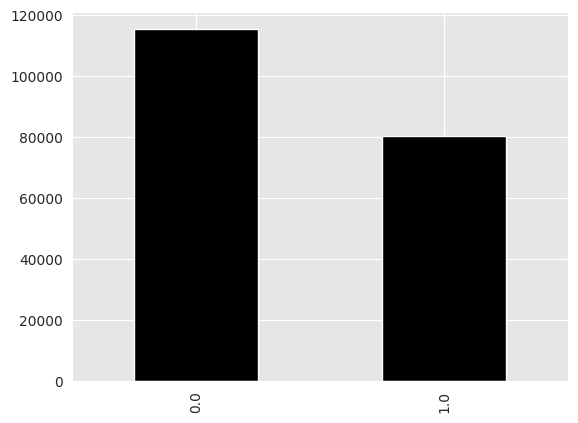

In [12]:
df[model_target].value_counts().plot.bar(color="black")
plt.show()

Keep in mind that we eventually want to build a model that can consider different groups. The sensitive attribute for this example will be the `RAC1P` feature. Let's plot a similar chart but include another dimension (the outcome). To do this, we need to group by the feature we want to encode. We also want to stack the bar chart to be able to compare to the bar chart above. We will set the `alpha` transparency value below 1 to better see the horizontal grid lines of the plot background.

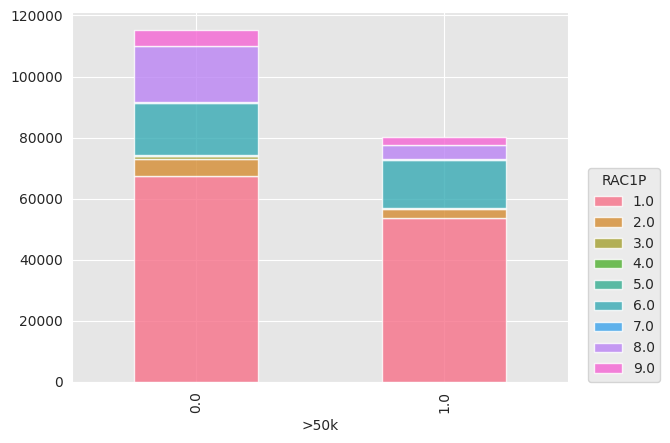

In [13]:
# Set color map for the different categories
cmap = sns.set_palette("husl", 9)

# Perform grouping based on target and feature
df.groupby([model_target, "RAC1P"])["RAC1P"].count().unstack().plot(
    kind="bar", stacked=True, alpha =.8
)

# Add legend
plt.legend(loc=(1.04, 0), title="RAC1P")
plt.show()

#### Feature distribution(s)
Let's start exploring other features (so far we only looked at the distribution of the target). The first feature we might want to explore, could be the sensitive attribute itself. It can be helpful to know how many groups we have in a sensitive feature column and how many instances there are per group.

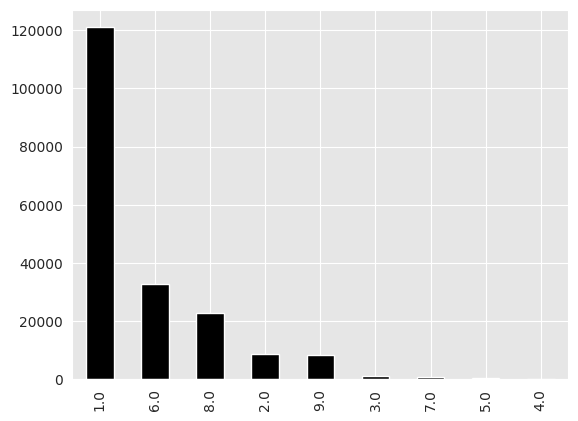

In [14]:
df["RAC1P"].value_counts().plot.bar(color="black")
plt.show()

Let's plot the same chart but include another dimension (the outcome). For this, we want to use another library, Seaborn. Seaborn has a method called `countplot()` which allows to pass a dataframe and feature columns as well as an additional column to use for color encoding.

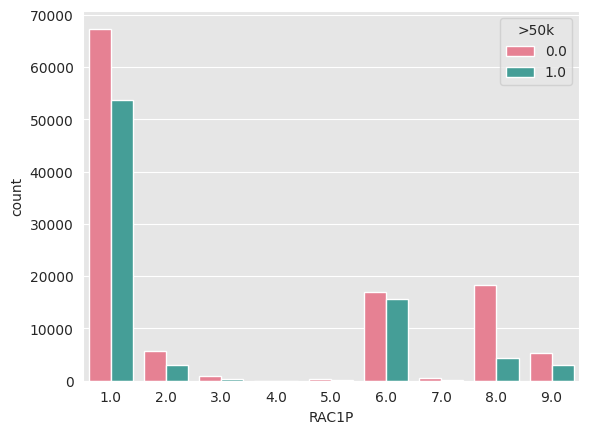

In [15]:
# We want to plot RAC1P on the x-axis and get counts; in addition we color based on model target category
sns.countplot(x="RAC1P", hue=model_target, data=df, palette="husl", dodge=True)

plt.show()

We can observe that the outcome is not equally distributed across all `RAC1P` categories. The biggest discrepancy appears to be category Nr. 8 - for this group we have almost 3x as many instances of income $\leq$ 50k as above 50k. Let's repeat this but for another feature (ideally one that we don't expect to be a contributing factor to the outcome such as grand parents living with grand children).

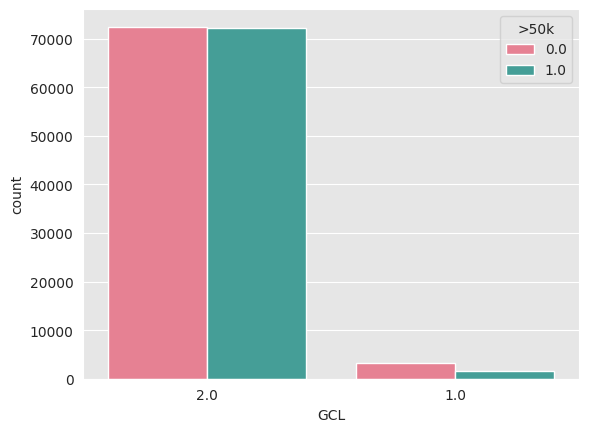

In [16]:
sns.countplot(x="GCL", hue=model_target, data=df, palette="husl", dodge=True)

plt.show()

Another type of barplot can be created with `.catplot()`. This method allows to specify 3 dimensions of encoding at the same time. We can specify the feature that we want counts for (e.g. count of how many instanced for each job category we have), generate comparison columns using a second feature and finally encode outcome as color again.

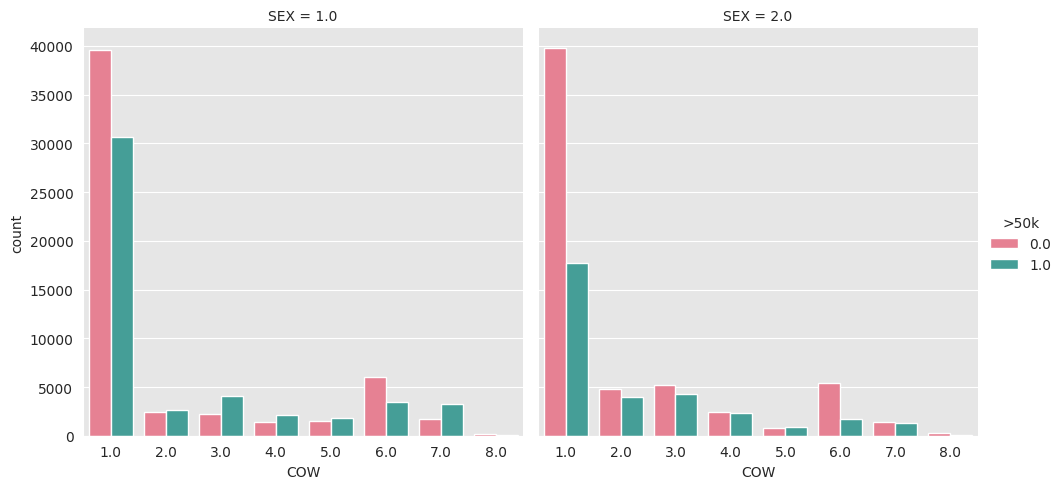

In [17]:
sns.catplot(x="COW", col="SEX", kind="count", hue=model_target, data=df, palette="husl")
plt.show()

The chart above allows us to observe a pay difference by sex and also by work class (job family).

### Histograms

Histograms show distributions of numeric data. Data is divided into "buckets" or "bins". We use histograms for numerical data to group datapoints together into buckets. The command to create a histogram is `df[<feature_name>].plot.hist(bins=n)`. Let's try this:

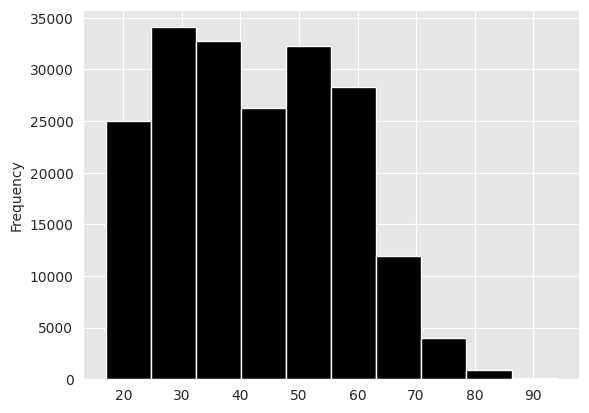

In [18]:
# Let's create 10 bins for analyzing the age feature
df["AGEP"].plot.hist(bins=10, color="black")
plt.show()

We might have expected a lognormal or normal distribution (with peak at around 45y) but are actually observing something that looks like a bi-modal distribution with a cut-off at 16. The cut-off occurs  because the `adult_filter` was applied when loading in the dataset in the beginning to mimic the UCI adult dataset; the double peak could indicate that we have 2 different sub-populations in the dataset. Once again, we might want to overlay another feature to check this. For this we can use Seaborn again. 

As we are working with numerical data now, we need to use `.displot()`. There are a lot of things we can specify, e.g. whether we want percentages, absolute counts, stacking the bars or displaying next to one another. For all the details, have a look at the documentation [here](https://seaborn.pydata.org/generated/seaborn.displot.html). This plotting method provides access to different types of histogram plots: 
- 'hist' (histrogram; instance counts per bin), 
- 'kde' (kernel-density-estimation) and 
- 'ecdf' (empirical-cumulative distributions). 
For a comparison of the methods, you can have a look [here](https://seaborn.pydata.org/tutorial/distributions.html).

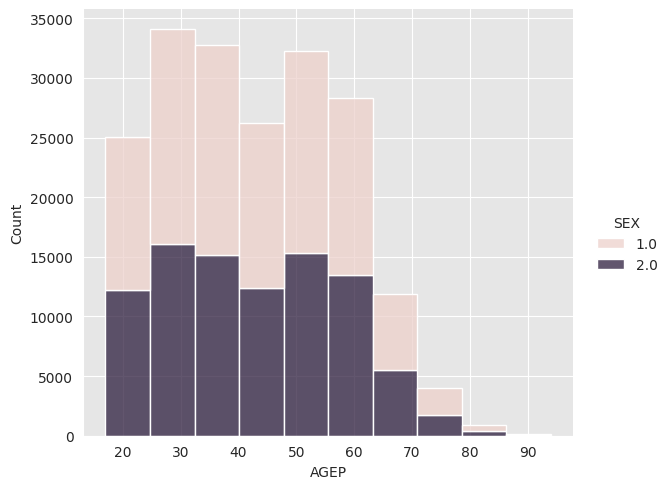

In [33]:
sns.displot(
    df,
    x="AGEP",
    hue="SEX",
    aspect=1.2,
    kind="hist",
    stat="count",
    bins=10,
    multiple="stack",
)
plt.show()

This visualization is not entirely conclusive; we can observe similar patters for both types of sex that are recorded in the data. This gives rise to the question whether there is a combination of attributes that leads to the bi-modal peaks we can observe.

We can also bin the age feature and split the plot by the model target. We would expect the younger age-groups to have lower salaries as they are more likely to still be in education or working lower salary jobs. To plot this, we can include a `col` parameter in `displot()`.

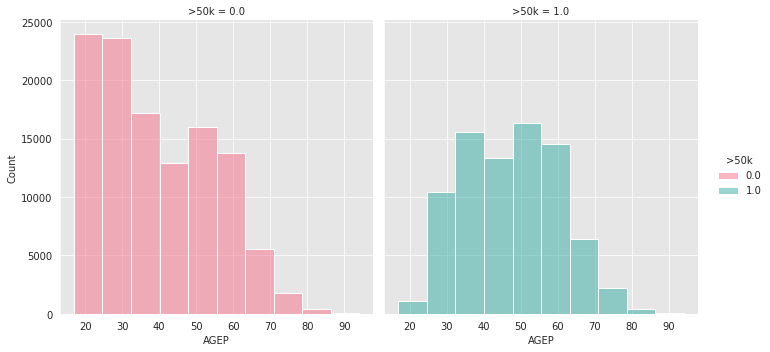

In [20]:
sns.displot(
    df,
    x="AGEP",
    col=model_target,
    bins=10,
    palette=sns.color_palette("husl", 2),
    hue=model_target,
)

plt.show()

The above is interesting as it suggest that we have different underlying age distributions for different outcome classes. We can look at this again by using the kernel density estimate option for plotting. 

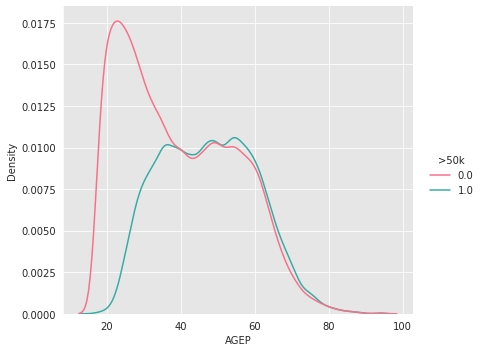

In [21]:
sns.displot(
    df,
    x="AGEP",
    hue=model_target,
    aspect=1.2,
    kind="kde",
    palette=sns.color_palette("husl", 2),
)
plt.show()

## 4. <a name="4">Scatter Plots</a>
(<a href="#0">Go to top</a>)

Scatter plots are simple 2D plots of two numerical variables that can be used to examine the relationship between two numerical variables. If one variable is moving up and so is the other, it is a so-called positive correlation. If one variable moves down and the other moves up, it is a negative correlation.

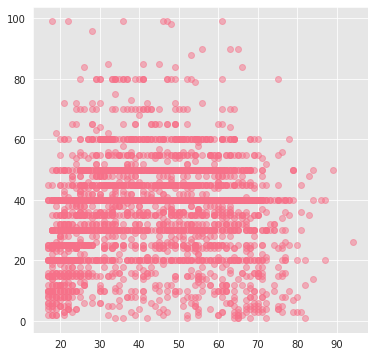

In [22]:
plt.figure(figsize=(6, 6))
plt.scatter(
    x="AGEP",
    y="WKHP",
    data=df.sample(5000, random_state=1), # we take a sample of data for quicker plotting 
    alpha=0.5,
)
plt.show()

We are not really observing any particular relationship. Let's try to overlay the outcome again by specifying a `hue`.

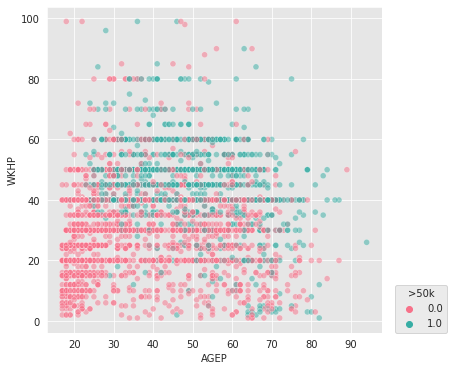

In [23]:
plt.figure(figsize=(6, 6))

sns.scatterplot(
    data=df.sample(5000, random_state=1), # we take a sample of data for quicker plotting 
    x="AGEP",
    y="WKHP",
    hue=model_target,
    palette=sns.color_palette("husl", 2),
    alpha=0.5,
)

# Add legend
plt.legend(loc=(1.04, 0), title=">50k")
plt.show()

Now we can actually see a pattern. Low age and low hours worked per hour show a higher occurence of salary $\leq$ 50k. Let's quantify this and have a look at correlations.

## 5. <a name="5">Correlation Matrix</a>
(<a href="#0">Go to top</a>)

Similar to scatterplots, the correlation matrix aims to pinpoint relationships between numerical features. Correlation values of -1 means perfect negative correlation, 1 means perfect positive correlation, and 0 means there is no relationship between the two numerical features.

Text(0.5, 1.0, 'Correlation Matrix')

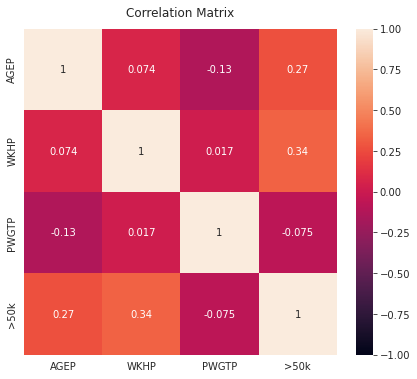

In [24]:
plt.figure(figsize=(7, 6))

heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title("Correlation Matrix", fontdict={"fontsize": 12}, pad=12)

As expected, we are seeing a positive correlation between age and salary as well as between hours worked and salary. However, does this also hold true if we split by sensitive feature?

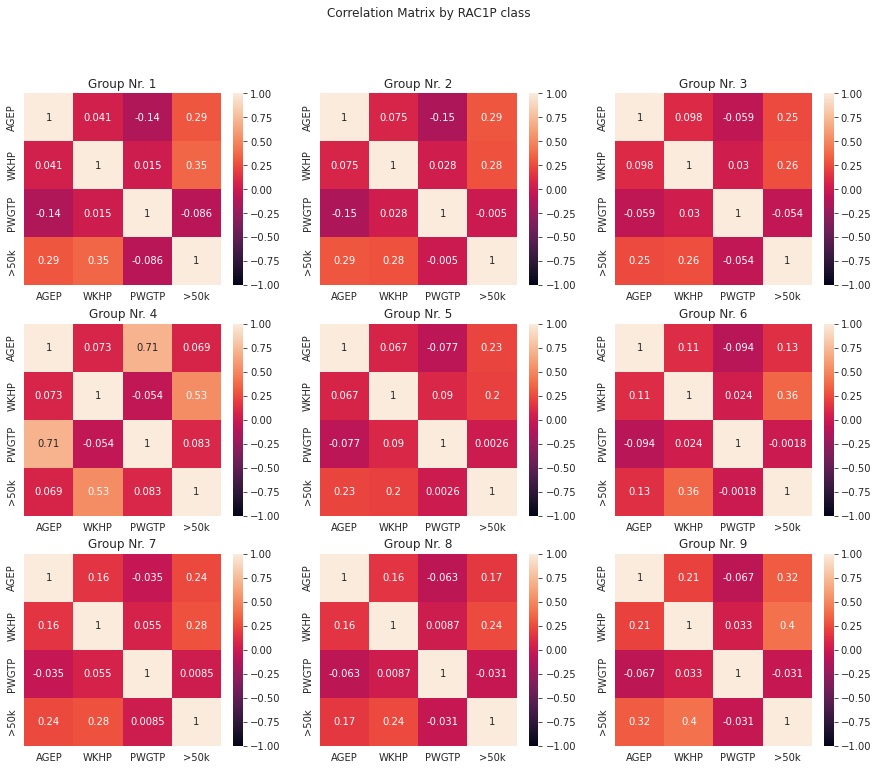

In [25]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
fig.suptitle("Correlation Matrix by RAC1P class")

tickers = sorted(df["RAC1P"].unique())
for i, ax in zip(tickers, axs.ravel()):
    sns.heatmap(
        df[df["RAC1P"] == i].corr(),
        ax=ax,
        vmin=-1,
        vmax=1,
        annot=True,
    )
    ax.set_title("Group Nr. %s" % str(int(i)))

Interestingly, age is less correlated with the outcome for certain groups. This could indicate, that being a member of a particular group has a bigger influence on the outcome than the age feature.

## 6. <a name="6">Difference in Proportion of Labels (DPL) and $CI_{norm}$</a>
(<a href="#0">Go to top</a>)

### Difference in Proportion of Labels
The difference in proportions of labels (DPL) compares the proportion of observed outcomes with positive labels for different groups in a dataset. More details about DPL can be found [here](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-data-bias-metric-true-label-imbalance.html).

> $DPL = \frac{n_{>50k \wedge RACP1=1}}{n_{RACP1=1}} - \frac{n_{>50k \wedge RACP1=8}}{n_{RACP1=8}}$

To calculate DPL we need to select 2 groups that we want to compare. From our analysis in the beginning, we know that for the feature `RAC1P` Group 1 and Group 8 have the biggest difference in outcome, so we want to use those groups for further analysis. It is possible to calculate DPL for > 2 groups by selecting one reference group and then comparing against that particular group. It is also possible to use multiple attributes to establish group membership (e.g. `RAC1P` and `SEX`).

We can slice dataframe using logical conditions:

In [26]:
n_50k_gr1 = len(df[(df['>50k']==1)&(df['RAC1P']==1)])
n_gr1 = len(df[df['RAC1P']==1])

n_50k_gr8 = len(df[(df['>50k']==1)&(df['RAC1P']==8)])
n_gr8 = len(df[df['RAC1P']==8])

We can now calculate $DPL$. For binary and multicategory outcomes, the DPL values range over the interval (-1, 1). 

- Positive DPL values indicate that having attribute $a$ (e.g. group membership "1") has a higher proportion of positive outcomes when compared with not having attribute $a$ (e.g. group membership "8").

- Values of DPL near zero indicate a more equal proportion of positive outcomes between groups with different attributes

- Negative DPL values indicate that not having attribute $a$ has a higher proportion of positive outcomes when compared with having attribute $a$.

In [27]:
dpl = n_50k_gr1/n_gr1 - n_50k_gr8/n_gr8
dpl

0.2490962739726761

We observe DPL of 0.25. This means members of group 1 has a higher proportion of positive outcomes.

### Class Imbalance (normalized)
Class imbalance (CI) occurs when there are different group sizes present in a dataset (groups based on sensitive attribute(s)). Here, we don't consider labels/outcomes and are focussing on the group sizes.

> $CI_{norm} = \frac{n_{RACP1=1}-n_{RACP1=8}} {n_{RACP1=1}+n_{RACP1=8}}$

CI values range from -1 to +1.
- Positive CI values indicate that the group with attribute $a$ contains more examples than the other group
- CI values near 0 indicate that the groups are similar sizes
- Negative CI values indicate that the group with attribute $a$ contains fewer examples than the other group

Once again, we can use dataframe slicing to calculate the values. In fact, we can use `n_gr1` and `n_gr8` from the $DPL$ calculation as these are the counts we need.

In [28]:
ci_norm = (n_gr1-n_gr8)/(n_gr1+n_gr8)
ci_norm

0.6829880597222512

We are clearly dealing with very imbalanced groups here. This will be very important to remember for next steps and also model selection. We will have to specify that the model target is imbalanced and also the groups we want to consider are different sizes. Keep in mind that generally models improve the more data we can provide. The same holds true for group-specific performance. We are dealing with target imbalance and group imbalance!